## The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Compute the camera matrix and distortion coefficients

camera_cal\calibration1.jpg
1
camera_cal\calibration10.jpg
camera_cal\calibration11.jpg
camera_cal\calibration12.jpg
camera_cal\calibration13.jpg
camera_cal\calibration14.jpg
camera_cal\calibration15.jpg
camera_cal\calibration16.jpg
camera_cal\calibration17.jpg
camera_cal\calibration18.jpg
camera_cal\calibration19.jpg
camera_cal\calibration2.jpg
camera_cal\calibration20.jpg
camera_cal\calibration3.jpg
camera_cal\calibration4.jpg
2
camera_cal\calibration5.jpg
3
camera_cal\calibration6.jpg
camera_cal\calibration7.jpg
camera_cal\calibration8.jpg
camera_cal\calibration9.jpg


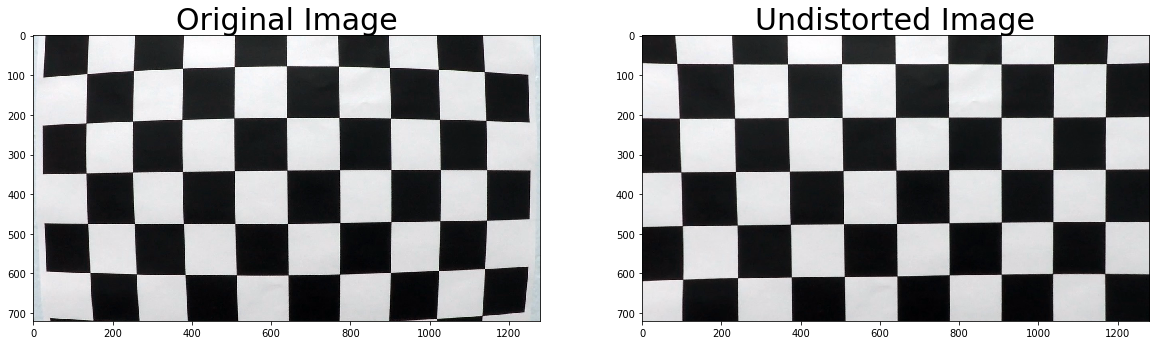

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Number of corners in the x and y 
nx = 9
ny = 6

objectPoints = [] # The 3D points in the real world
imagePoints = [] # The 2D points in an image plane

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Preparing the object points
objp = np.zeros((6*9,3), np.float32)

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
i = 0
imglist = []
# go through each image in the list
for fname in images:

    print(fname)
    img = cv2.imread(fname)

    # Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    if ret == True:
        imagePoints.append(corners)
        objectPoints.append(objp)

        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        imglist.append(img)
    else:
        i += 1
        print(i)
        
# Test the undistortion on an image
img = cv2.imread('camera_cal\calibration1.jpg')


# Calibrate the camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectPoints, imagePoints, img.shape[0:2], None, None)

# Find the destination image
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

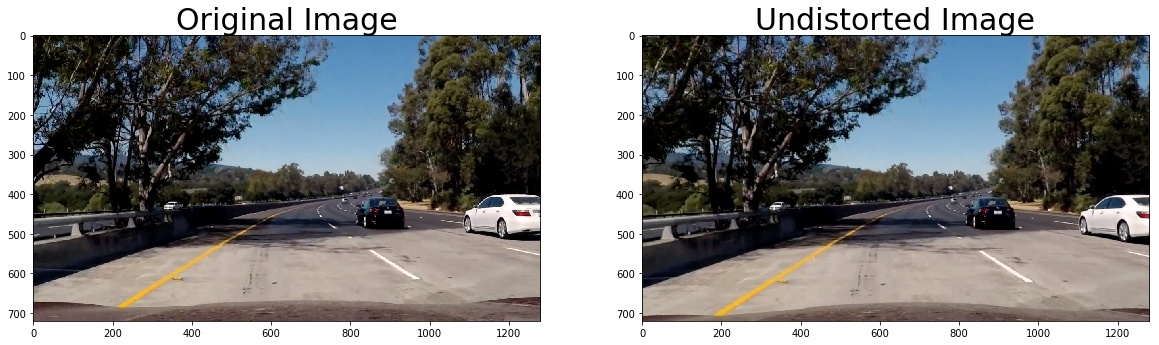

In [2]:
# Here is the original raw image from the camera and the undistorted image
image = cv2.imread('test_images/test5.jpg')
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
dst = cv2.undistort(img, mtx, dist, None, mtx)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

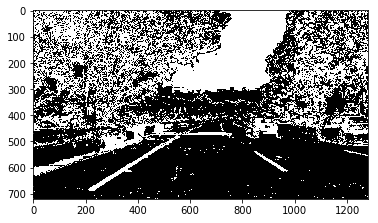

In [3]:
# Now we are going to apply a combination of color and gradient thresholds to find the rectify binary image

image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]

thresh = (90, 255)
s_binar = np.zeros_like(s_channel)
s_binar[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1


# Use HLS color space and focus using the 

def abs_sobel_thresh(img, orient, sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    
     # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sbinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    
     # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    mag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(mag)
    # 6) Return this mask as your binary_output image
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return sxbinary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    arctan = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binaryMask = np.zeros_like(arctan)
    binaryMask[(arctan >= thresh[0]) & (arctan <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binaryMask


# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(10, 100))
#plt.imshow(gradx, cmap = 'gray')
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(10, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Combine the two binary thresholds
combined_binary = np.zeros_like(s_binar)
combined_binary[(s_binar == 1) | (combined == 1)] = 1
plt.imshow(combined_binary, cmap = 'gray')

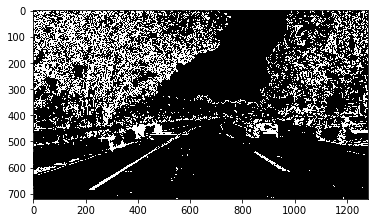

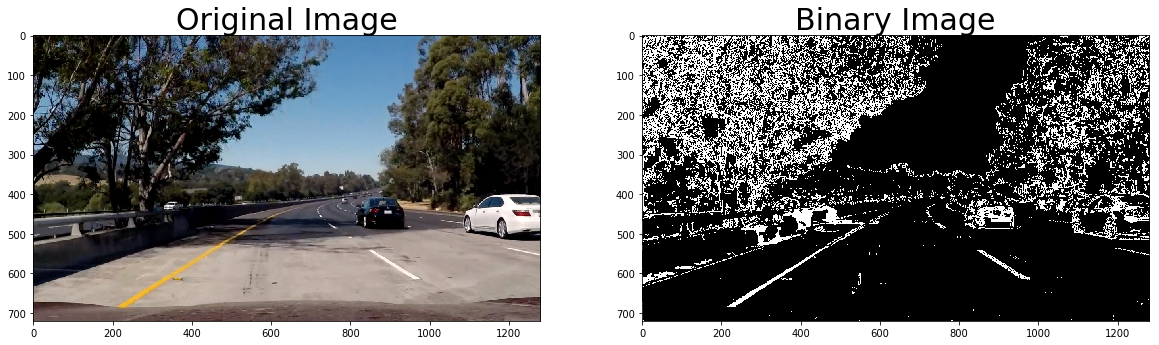

In [4]:
image = cv2.imread('test_images/test5.jpg')
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def cvtToBinary():
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    plt.imshow(combined_binary, cmap='gray')
    return combined_binary
binary = cvtToBinary()

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Binary Image', fontsize=30)

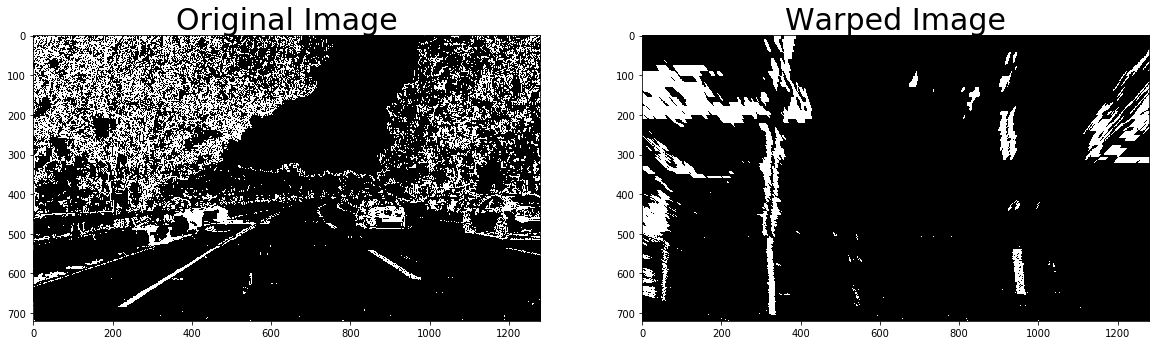

In [5]:
# Apply perspective transform
image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

draws = image
src = np.float32(
    [[150, 720], # Bottom Left
    [1135, 720], # Bottom Right
    [585, 460],  # Top Left
    [735, 460]]) # Rop Right
dst = np.float32(
    [[320, 720],
    [960, 720],
    [320, 0],
    [960, 0]])

# Draw the lines for the points of interest (source)
# # Left line
# cv2.line(draws, (src[0][0], src[0][1]), (src[2][0], src[2][1]), (255,0,0), thickness = 5)
# # Right Line
# cv2.line(draws, (src[1][0], src[1][1]), (src[3][0], src[3][1]), (255,0,0), thickness = 5)
# # Bottom Line
# cv2.line(draws, (src[0][0], src[0][1]), (src[1][0], src[1][1]), (255,0,0), thickness = 5)
# # Top Line
# cv2.line(draws, (src[2][0], src[2][1]), (src[3][0], src[3][1]), (255,0,0), thickness = 5)

# # Draw the lines for the destiation 
# # Left Line
# cv2.line(draws, (dst[0][0], dst[0][1]), (dst[2][0], dst[2][1]), (255,0,0), thickness = 5)
# # Right Line
# cv2.line(draws, (dst[1][0], dst[1][1]), (dst[3][0], dst[3][1]), (255,0,0), thickness = 5)
# # Bottom Line
# cv2.line(draws, (dst[0][0], dst[0][1]), (dst[1][0], dst[1][1]), (255,0,0), thickness = 5)
# # Top Line
# cv2.line(draws, (dst[2][0], dst[2][1]), (dst[3][0], dst[3][1]), (255,0,0), thickness = 5)



#Combination of both hough lines and normal image
#comboImage =  weighted_img(houghTransform, initial_image, α=0.8, β=1., λ=0.)
def perspectiveTrans(img, bin):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0])
    # Calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Calculate the inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp an image
    warped = cv2.warpPerspective(binary, M, img_size)
    
    return M, Minv, warped

camMat, invCamMat, warpedImg = perspectiveTrans(image, binary)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(binary, cmap = 'gray')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warpedImg, cmap = 'gray')
ax2.set_title('Warped Image', fontsize=30)

In [17]:
print(np.int(warpedImg.shape[0]/2))

360


In [18]:
# Find the lane lines using a histogram


print(warpedImg)
# def findLaneLines():
# Create a historgram of the bottom half of the warped binary image
indicies = np.int(warpedImg.shape[0]/2)
histogram = np.sum(warpedImg[indicies:,:], axis=0)
# Create an image to draw on
outputImg = np.dstack((warpedImg, warpedImg, warpedImg))*255

#Save initial points where the peaks are for the left and right half of the histogram
midpoint = np.int(histogram.shape[0]/2)
leftxBase = np.argmax(histogram[:midpoint])
rightxBase = np.argmax(histogram[midpoint:]) + midpoint

# Set how many windows to fill vertically the whole frame
numOfWindows = 9

# Set the window height
windowHeight = np.int(warpedImg.shape[0]/numOfWindows)

# Store all the none 0 pixels of each axis
notZero = warpedImg.nonzero()
notZeroy = np.array(notZero[0])
notZerox = np.array(notZero[1])

# Keep track of the current positions
leftxCurrent = leftxBase
rightxCurrent = rightxBase


margin = 100

minpix = 50

leftLaneInds = []
rightLaneInds = []

# Step through every window
for window in range(numOfWindows):
    # Find window boundaries
    winyLow = warpedImg.shape[0] - (window + 1)*windowHeight
    winyHigh = warpedImg.shape[0] - window*windowHeight
    winxLeftLow = leftxCurrent - margin
    winxLeftHigh = leftxCurrent + margin
    winxRightLow = rightxCurrent - margin
    winxRightHigh = rightxCurrent + margin

    # Draw the windows
    cv2.rectangle(outputImg,(winxLeftLow,winyLow),(winxLeftHigh,winyHigh), (0,255,0), 2)
    cv2.rectangle(outputImg,(winxRightLow,winyLow),(winxRightHigh,winyHigh), (0,255,0), 2)

    # Find and store the hot pixels
#         good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
#         good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    leftInd = ((notZeroy >= winyLow) & (notZeroy < winyHigh) & (notZerox >= winxLeftLow) & (notZerox < winxLeftHigh)).nonzero()[0]
    rightInd = ((notZeroy >= winyLow) & (notZeroy < winyHigh) & (notZerox >= winxRightLow) & (notZerox < winxRightHigh)).nonzero()[0]
    leftLaneInds.append(leftInd)
    rightLaneInds.append(rightInd)
    if len(leftInd) > minpix:
        leftxCurrent = np.int(np.mean(notZerox[leftInd]))
    if len(rightInd) > minpix:
        rightxCurrent = np.int(np.mean(notZerox[rightInd]))

# Concatenate the arrays of the indicies
leftLaneInds = np.concatenate(leftLaneInds)
rightLaneInds = np.concatenate(rightLaneInds)

# Extract left and right line pixels
leftx = notZerox[leftLaneInds]
lefty = notZeroy[leftLaneInds]
rightx = notZerox[rightLaneInds]
righty = notZeroy[rightLaneInds]

# Fit a line to each
leftFit = np.polyfit(lefty, leftx, 2)
rightFit = np.polyfit(righty, rightx, 2)
        
    
#     return null

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


(720, 0)

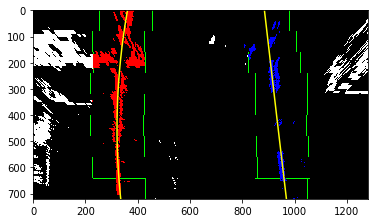

In [21]:
## visualize the lines
ploty = np.linspace(0, warpedImg.shape[0]-1, warpedImg.shape[0] )
leftFitx = leftFit[0]*ploty**2 + leftFit[1]*ploty + leftFit[2]
rightFitx = rightFit[0]*ploty**2 + rightFit[1]*ploty + rightFit[2]

outputImg[notZeroy[leftLaneInds], notZerox[leftLaneInds]] = [255, 0, 0]
outputImg[notZeroy[rightLaneInds], notZerox[rightLaneInds]] = [0, 0, 255]
plt.imshow(outputImg)
plt.plot(leftFitx, ploty, color='yellow')
plt.plot(rightFitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
    

(720, 0)

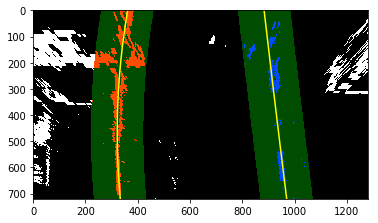

In [25]:
# If you already found a lane line before than use this to find the next
notZero = warpedImg.nonzero()
notZeroy = np.array(notZero[0])
notZerox = np.array(notZero[1])

margin = 100

leftLaneInds = ((notZerox > (leftFit[0]*(notZeroy**2) + leftFit[1]*notZeroy + leftFit[2] - margin)) & (notZerox < (leftFit[0]*(notZeroy**2) + leftFit[1]*notZeroy + leftFit[2] + margin)))
rightLaneInds = ((notZerox > (rightFit[0]*(notZeroy**2) + rightFit[1]*notZeroy + rightFit[2] - margin)) & (notZerox < (rightFit[0]*(notZeroy**2) + rightFit[1]*notZeroy + rightFit[2] + margin)))

# Get left and right lane line pixel positions
leftx = notZerox[leftLaneInds]
lefty = notZeroy[leftLaneInds]
rightx = notZerox[rightLaneInds]
righty = notZeroy[rightLaneInds]

# Fit the line
leftFit = np.polyfit(lefty, leftx, 2)
rightFit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0,warpedImg.shape[0]-1, warpedImg.shape[0])
leftFitx = leftFit[0]*ploty**2 + leftFit[1]*ploty + leftFit[2]
rightFitx = rightFit[0]*ploty**2 + rightFit[1]*ploty + rightFit[2]


## Now visualize the rults
outImg = np.dstack((warpedImg, warpedImg, warpedImg))*255
windowImg = np.zeros_like(outImg)

# Color in left and right line
outImg[notZeroy[leftLaneInds], notZerox[leftLaneInds]] = [255,0,0]
outImg[notZeroy[rightLaneInds], notZerox[rightLaneInds]] = [0,0,255]

# Generate a polygon to illustrate the search window area and recast the x and y points into usable format for cv2.fillPoly()
leftLinWindow1 = np.array([np.transpose(np.vstack([leftFitx-margin, ploty]))])
leftLinWindow2 = np.array([np.flipud(np.transpose(np.vstack([leftFitx+margin, ploty])))])
leftLinePts = np.hstack((leftLinWindow1, leftLinWindow2))
rightLineWindow1 = np.array([np.transpose(np.vstack([rightFitx-margin, ploty]))])
rightLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([rightFitx+margin, ploty])))])
rightLinePts = np.hstack((rightLineWindow1, rightLineWindow2))

# Draw the lane onto the warped blank image
cv2.fillPoly(windowImg, np.int_([leftLinePts]), (0,255, 0))
cv2.fillPoly(windowImg, np.int_([rightLinePts]), (0,255, 0))
result = cv2.addWeighted(outImg, 1, windowImg, 0.3, 0)
plt.imshow(result)
plt.plot(leftFitx, ploty, color='yellow')
plt.plot(rightFitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


In [29]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
yEval = np.max(warpedImg.shape[0])
leftCurverad = ((1 + (2*leftFit[0]*yEval + leftFit[1])**2)**1.5) / np.absolute(2*leftFit[0])
rightCurverad = ((1 + (2*rightFit[0]*yEval + rightFit[1])**2)**1.5) / np.absolute(2*rightFit[0])
print(leftCurverad, rightCurverad)
# Example values: 1926.74 1908.48

2763.61272392 82585.9358904


In [32]:
# We will warp the image back to image space and place highlight the lane

# Create an image to draw the lines on
warp_zero = np.zeros_like(warpedImg).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, invCamMat, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

NameError: name 'undist' is not defined